In [21]:
from poloniex import Poloniex
polo = Poloniex()
import os, datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import plotly_express as px

#input date time and Symbol
startdate = '1/11/2010'
end_date= '31/12/2018'
Symbol = 'USDT_BTC'

#time categories:  300, 900, 1800, 7200, 14400, and 86400(daily).


#pull HISTORICAL DATA
#86400 denotes daily
import pandas as pd
Daily_data =polo.returnChartData(Symbol, 7200, start= datetime.datetime.strptime(startdate, "%d/%m/%Y").timestamp(), end= datetime.datetime.strptime(end_date, "%d/%m/%Y").timestamp())
Daily_data = pd.DataFrame(Daily_data)
Daily_data['True Date']= pd.to_datetime(Daily_data['date'], unit='s')
Daily_data['Year']=  Daily_data['True Date'].dt.year
#moving average columns
Daily_data['MA10'] = Daily_data['close'].rolling(10).mean()
Daily_data['MA50'] = Daily_data['close'].rolling(50).mean()
Daily_data['EMA10'] = Daily_data['close'].ewm(span = 10).mean()
Daily_data['EMA50'] = Daily_data['close'].ewm(span = 50).mean()
#Rules
#Signal cross of 10 over 50 Buy at close price Logic 10>50 or short 10<50
#Always gong to be long or short
#Use closing prices
#Profit/Loss -- For buy (10>50) profit = close on day of cross until until 10<50 Reversal.
#Profit/Loss -- For Sell this is the reverse
#charts: Line chart, sma's and closing price
#profit LOSS calculator

Daily_data.head(2)

,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA50,EMA10,EMA50
0,225.0,1424368800,225.0,225.0,225.0,0.004444,0.999999,225.000000,2015-02-19 18:00:00,2015,NaN,NaN,225.00,225.00
1,244.0,1424376000,244.0,225.0,225.0,0.188671,45.275877,239.972316,2015-02-19 20:00:00,2015,NaN,NaN,235.45,234.69


In [22]:
#drop the Nan to get to the start of the moving averages
Daily_data_SMA= Daily_data.dropna()

In [23]:
#create the long/short column:
def buy_sell (row):
   if row['MA10'] > row['MA50'] :
      return 'LONG'
   if row['MA10'] < row['MA50'] :
      return 'SHORT'    
longshort = Daily_data.apply (lambda row: buy_sell(row), axis=1)
Daily_data_SMA['Go Long or Short'] = longshort


C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
#Find where the column values change
#this function compares current value to previous value and if they are the same = True
#If current value does not equal then it is false.
#Therefore all the "false" tags will have an exit price for our long and a entry price for our short
Daily_data_SMA['entry and exit'] = Daily_data_SMA['Go Long or Short'].eq(Daily_data_SMA['Go Long or Short'].shift())
Daily_data_SMA.to_csv('SMA.csv')

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
#Lets pull out all the entry and exit points with closing price and Short or long column
EntryandExit = Daily_data_SMA.loc[Daily_data_SMA['entry and exit'] == False]
EntryandExit
#NEXT Calculate the profit/Loss per trade
#Step 1 Change all the rows named SHORT to Negative
EntryandExit.loc[EntryandExit['Go Long or Short'] == 'LONG', 'close'] = EntryandExit['close']*-1
#Calculate the profit or loss on the trades. Fist column will be nan after that the profit or 
#loss is calculated on a per trade basis

#EntryandExit['Running Total'] = EntryandExit['Profit or Loss'].cumsum()
EntryandExit['Profit or Loss'] =  EntryandExit.close+EntryandExit.close.shift(1) 
#Cumulative Profit or loss
EntryandExit['Cumulative Profit or Loss'] =  EntryandExit['Profit or Loss'].cumsum()

EntryandExit.head(4)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA50,EMA10,EMA50,Go Long or Short,entry and exit,Profit or Loss,Cumulative Profit or Loss
49,235.000026,1424721600,235.000026,235.000026,235.000026,0.000000,0.000000,235.000026,2015-02-23 20:00:00,2015,235.000021,240.295046,235.603651,239.127936,SHORT,False,NaN,NaN
70,-237.750000,1424872800,237.750000,237.750000,237.750000,0.000000,0.000000,237.750000,2015-02-25 14:00:00,2015,238.975004,238.960048,238.386091,238.324387,LONG,False,-2.749974,-2.749974
72,237.750000,1424887200,237.750000,237.750000,237.750000,0.000000,0.000000,237.750000,2015-02-25 18:00:00,2015,238.750000,238.860048,238.175813,238.277703,SHORT,False,0.000000,-2.749974
80,-237.750000,1424944800,237.750000,237.750000,237.750000,0.000013,0.003053,237.750000,2015-02-26 10:00:00,2015,237.750000,237.555048,237.835510,238.127286,LONG,False,0.000000,-2.749974


In [26]:
#trade statistics
total_trades= len(EntryandExit)
Total_profit_points = EntryandExit['Profit or Loss'].sum()
largest_drawdown = EntryandExit['Profit or Loss'].min()
largest_winner = EntryandExit['Profit or Loss'].max()

print(f"There were {total_trades} trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the \
strategy was ${Total_profit_points}. The largest single winner was ${round(largest_winner,2)} and the largest drawdown was ${round(largest_drawdown,2)}")

There were 458 trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the strategy was $19680.733463790013. The largest single winner was $4162.09 and the largest drawdown was $-3347.0


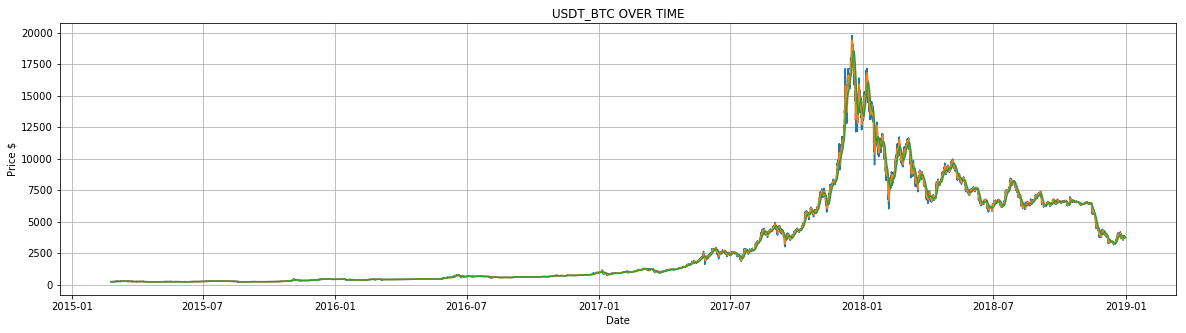

In [27]:
#Plot price and moving averages
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5)) 
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['close'])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['MA10'])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['MA50'])

# Incorporate the other graph properties
plt.title(f"{Symbol} OVER TIME")
plt.ylabel("Price $")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()


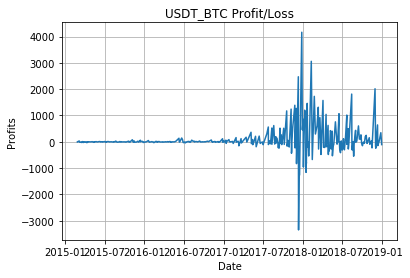

In [28]:
#Plot profit line
import matplotlib.pyplot as plt
plt.plot(EntryandExit['True Date'], EntryandExit['Profit or Loss'])

# Incorporate the other graph properties
plt.title(f"{Symbol} Profit/Loss")
plt.ylabel("Profits")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()